# Exercise 12: Interpretability

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras

# import layers we may use
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

# import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots
import nets

### Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
### Numpy version: 1.19.5
### Scikit-learn version: 0.24.1
### Tensorflow version: 2.4.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### Load Fashion-MNIST data.

In [3]:
from tensorflow.keras.datasets import fashion_mnist
def load_preprocess_fashion_mnist(minmax_normalize=True):
    
    labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    train, testval = fashion_mnist.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    if len(train_x.shape) < 4:
        train_x = train_x.reshape(-1, 28, 28, 1)
        val_x = val_x.reshape(-1, 28, 28, 1)
        test_x = test_x.reshape(-1, 28, 28, 1)
    
    return train_x, train_y, test_x, test_y, val_x, val_y, np.array(labels)

In [4]:
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_fashion_mnist()

In [5]:
def create_compile_cnn_interp(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'CNN'    
    model = keras.models.Sequential(name=name)
    
    input_layer = Input(shape=input_shape, name='input')
    model.add(input_layer)
    model.add(Conv2D(32, kernel_size=(7,7), padding='same', activation='relu', name='conv1'))
    model.add(MaxPooling2D((2,2), name='maxpool1')) 
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', name='conv2'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', name='conv3'))
    model.add(MaxPooling2D(2, name='maxpool2'))
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv4'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv5'))
    model.add(MaxPooling2D(2, name='maxpool3'))
    
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout1'))
             
    model.add(Dense(164, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    
    model.add(Dense(num_outputs, name='linear_output'))
    # add activation by itself as last layer
    model.add(tf.keras.layers.Activation('softmax'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        model.summary()
        #linear_part.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # take the layers of 'model' except the softmax activation as a linear model; we'll use it to compute saliency maps
    linear_part = keras.Model(inputs=[input_layer], outputs=[model.get_layer('linear_output').output])
    
    return name, model, linear_part

In [6]:
model_fp = 'fmnist.h5'
model_linear_fp = 'fmnist-linpart.h5'

load = os.path.exists(model_fp)

if load:
    model = keras.models.load_model(model_fp)
    linear_part = keras.models.load_model(model_linear_fp)
else:
    name, model, linear_part = create_compile_cnn_interp(verbose=True)

    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    max_epochs = 5
    batch_size = 256

    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, callbacks=[early_stop_cb])

    # save the model
    model.save(model_fp)
    linear_part.save(model_linear_fp)
    
model.trainable = False
linear_part.trainable = False

In [7]:
# get predicted label and confidence value for it
def pred_label_and_conf(model, x):
    preds = model.predict(x)[0]
    pred_label = np.argmax(preds)
    pred_conf = preds[pred_label]
    
    return pred_label, pred_conf

In [8]:
# we want to get the gradient of the logit wrt the input
def gradient_wrt_input(linear_part_model, in_x, class_label):
    with tf.GradientTape() as tape:
        tape.watch(in_x) # tell the tape to watch in_x
        y_pred = linear_part_model(in_x) # get the prediction on the linear_part_model
        logits = y_pred[:, class_label] # compute the prediction wrt that label (this is the logits)
        
    return tape.gradient(logits, in_x) # grab the gradient with respect to the input

In [9]:
def compute_saliency_map(linear_part_model, in_x, class_label, take_abs=True, eps=1e-14):
    
    # Grab the gradient vec
    grad_vec = gradient_wrt_input(linear_part_model, in_x, class_label)
    
    # If we have multiple channels then we need to take the maximum across them
    grad_vec = tf.reduce_max(grad_vec, axis=-1)
    
    # convert to numpy
    grad_vec_np = grad_vec.numpy()
    
    if take_abs:
        grad_vec_np = np.abs(grad_vec_np)
    
    # we need to min-max normalize the vector
    minv = np.min(grad_vec_np)
    maxv = np.max(grad_vec_np)
    
    # use a small smoothing eps for the calculation
    saliency_map = (grad_vec_np - minv) / (maxv - minv + eps)
    
    return saliency_map

### Let's create some explanations using saliency maps

In [10]:
def plot_example_with_saliency(model, linear_part, in_x):
    
    pred_label, in_conf = pred_label_and_conf(model, in_x)

    titles = ['Label: {} (conf: {:.3f})'.format(pred_label, in_conf), 
              'Saliency Map']

    # convert in_x to a tensor
    in_x_as_tensor = tf.convert_to_tensor(in_x, dtype=tf.float32)

    # notice here we use the linear part for this
    saliency_map = compute_saliency_map(linear_part, in_x_as_tensor, pred_label)

    images = np.r_[in_x.reshape(1, 28, 28), saliency_map.reshape(1, 28, 28)]

    plots.plot_images(images, dim_x=28, dim_y=28, fig_size=(8, 3), cmap=['gray', 'jet'], titles=titles, titles_fontsize=12)

Example 0 - True label: 2 (pullover)


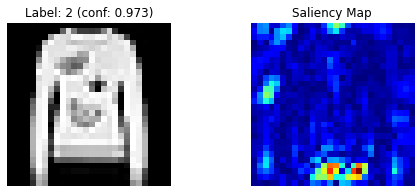

Example 1 - True label: 3 (dress)


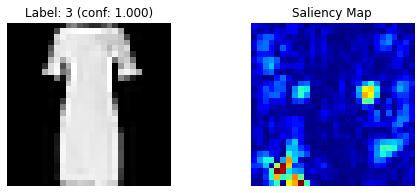

Example 7 - True label: 9 (ankle boot)


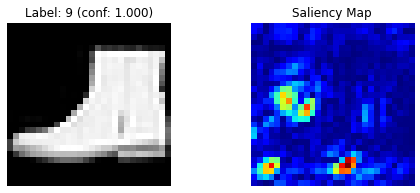

Example 19 - True label: 9 (ankle boot)


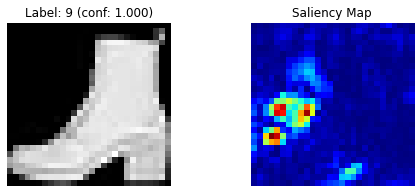

Example 89 - True label: 9 (ankle boot)


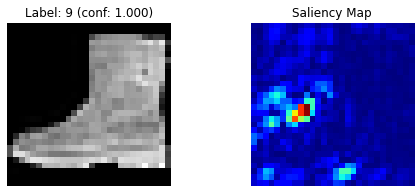

In [11]:
# show some examples
for ex_idx in [0, 1, 7, 19, 89]:
    in_x = test_x[ex_idx].reshape(1, 28, 28, 1)
    in_y = test_y[ex_idx]
    
    print('Example {} - True label: {} ({})'.format(ex_idx, in_y, labels[in_y]))
    plot_example_with_saliency(model, linear_part, in_x)

### See exercise 11 for details

In [12]:
# for the attack we need to be able to get the gradient of the loss with respect to the input
def gradient_of_loss_wrt_input(model, in_x, y_target, num_classes=10):
    with tf.GradientTape() as tape:
        tape.watch(in_x) # tell the tape to watch in_x
        y_pred = model(in_x) # get the prediction on the model
        loss = keras.losses.sparse_categorical_crossentropy(y_target, y_pred) # compute the loss
        
    return tape.gradient(loss, in_x) # gradient of the loss with respect to the input

In [13]:
# Implementation of the Fast Gradient Sign Method (FGSM)
def do_fgsm(model, in_x, y_target, eps):
    grad_vec = gradient_of_loss_wrt_input(model, in_x, y_target)
    
    perturb = tf.sign(-grad_vec)
    adv_x = in_x + eps * perturb
    adv_x = tf.clip_by_value(adv_x, 0, 1.0) # clip
    
    return adv_x, perturb

Epsilon: 0.01 --- 


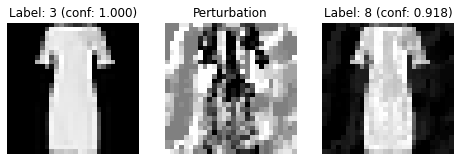

In [14]:
ex_idx = 1
in_x = test_x[ex_idx].reshape(-1, 28, 28, 1)
in_y = test_y[ex_idx]

_, in_conf = pred_label_and_conf(model, in_x)

# we need it to be a tensor so we can take the gradient of the loss with respect to it
adv_x = tf.convert_to_tensor(in_x.reshape(1, 28, 28, 1), dtype=tf.float32)

target_label = 8
eps = 0.01
conf_exit_early = 0.9
num_attack_iter = 100

for i in range(0, num_attack_iter):
    # do one step of FGSM
    adv_x, _ = do_fgsm(model, adv_x, target_label, eps)

    # check if predicted label is the target
    adv_label, adv_conf = pred_label_and_conf(model, adv_x)

    # if so and confidence is above threshold, exit early
    if adv_label == target_label and adv_conf > conf_exit_early: 
        break

# perturbation is just the difference between the adversarial sample and the starting data point
perturb = adv_x - in_x

titles = ['Label: {} (conf: {:.3f})'.format(in_y, in_conf), 'Perturbation',
          'Label: {} (conf: {:.3f})'.format(adv_label, adv_conf)]

images = np.r_[in_x, perturb, adv_x]

# plot images
print('Epsilon: {} --- '.format(eps))
plots.plot_images(images, dim_x=28, dim_y=28, fig_size=(8, 3), titles=titles, titles_fontsize=12)
print()

Example 1 - True label: 3 (dress)


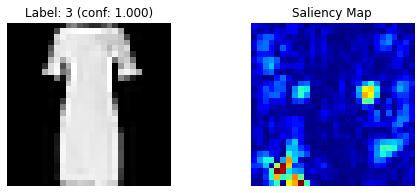

Perturbation - Predicted label: 8 (bag)


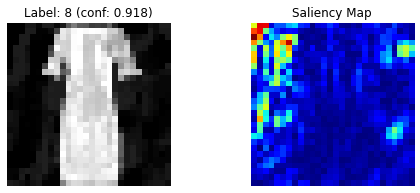

In [15]:
print('Example {} - True label: {} ({})'.format(ex_idx, in_y, labels[in_y]))
plot_example_with_saliency(model, linear_part, in_x)

print('Perturbation - Predicted label: {} ({})'.format(target_label, labels[target_label]))
plot_example_with_saliency(model, linear_part, adv_x.numpy())

## Note: there are libraries if you want to visualize models decision in the forms of saliency maps etc. For example: https://pypi.org/project/tf-keras-vis/